## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import random
from collections import Counter

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.metrics import accuracy_score
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
import utils.graph_utils as gu
import utils.data_utils as du
import utils.model_utils as mu 
import utils.visual_utils as vu
from utils.model_utils import TrainNN
from utils.cka import CKACalculator

# tracking 
import wandb

#visualizations
import mne
import matplotlib.pyplot as plt

## Constants

In [49]:
# Path constants
path="artifacts"
data_path = "../data/"
metadata_path = data_path + "sample_metadata.tsv"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
saved_path = "runs_results/models"
node_labels_path = "node_names.tsv"
node_labels = [x.split("\t")[0] for x in list(pd.read_csv(node_labels_path).iloc[:,0])]
model_obj_path = "model_runs/"

# Data preprocessing constants
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}
has_val_set = False

# Model architecture
model_arch = {
    "model":DGCNN,
    "chans" : 5,
    "electrodes" : 22,
    "outputs" : 5,
    "layers" : 2,
    "hid_chans" : 16
    }

# Training parameters
train_dict = {
    "lr": 1e-4,
    "epochs": 40,
    "w_decay": 1e-3,
    }

#Models 
model_meta ={
    "amount":1,
    "plot":True,
    "new_models":True,
    "name": "dgcnn_mod"
    }

### Read data

In [3]:
## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(metadata_path, sep='\t')

# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

X_bde = du.band_preprocess(X, preprocessed_data_path)     

### Split data into train, validation and test sets

In [4]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=42)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=42)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Train models

In [5]:
def train_models(modeltrainer,dict_model_arch, dict_training,dict_model_meta, path=path):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    mods = []
    for i in range(dict_model_meta["amount"]):   
            tmp_mod = dict_model_arch["model"](in_channels=dict_model_arch["chans"], 
                                            num_electrodes=dict_model_arch["electrodes"], 
                                            hid_channels=dict_model_arch["hid_chans"], 
                                            num_layers=dict_model_arch["layers"],
                                            num_classes=dict_model_arch["outputs"])
            
            mod_name=dict_model_meta["name"]
            
            model_path=f"{path}/{mod_name}_{i}.pth"

            if dict_model_meta["amount"]>1:
                print(f"Model {i+1}")
                
            if not os.path.exists(model_path):
                    print(f"[train_models]: Could not resolve path: {model_path}")
                    dict_model_meta["new_models"]=True
                
            if dict_model_meta["new_models"] or not os.path.exists(model_path):
                
                print(f"[train_models]: Training new models")
                trainer = modeltrainer()
                
                mods.append(trainer.train_model(tmp_mod, train_loader, 
                                                    path=model_path,
                                                    name=mod_name,
                                                    has_val_set=False,
                                                    val_loader=None,
                                                    learning_rate=dict_training["lr"],
                                                    w_decay=dict_training["w_decay"],
                                                    epochs=dict_training["epochs"], 
                                                    prints=dict_model_meta["plot"],
                                                    modrun=i))   
            else:
                print(f"[train_models]: Loading models from {model_path}")
                tmp_mod.load_state_dict(torch.load(model_path))
                tmp_mod.eval()
                mods.append([tmp_mod,[]])
    return mods

In [6]:
def seed_all(seed):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def run_models_hpc(param_list, n_runs, dict_model_arch, dict_training, dict_model_meta):

    run_idx = 1
    while run_idx < n_runs:
        random_seed = random.randint(0, 999999)
        seed_all(random_seed)
        path_name = model_obj_path + f"run_{run_idx}_seed_{random_seed}"
        print(f"[run_models_hpc] : Run idx: {run_idx}  | Curr seed: {random_seed}")
        print(f"[run_models_hpc] : Model dir: {path_name}")
        os.makedirs(path_name)
        models_dict = dict([(x, []) for x in param_list])
        
        for n_chans in param_list:
            model_name = f"model_chans_{n_chans}_seed_{random_seed}"
            
            new_dict_arch = dict_model_arch
            new_dict_arch["hid_chans"] = n_chans
            
            new_dict_meta = dict_model_meta
            new_dict_meta["name"] = model_name
            
            curr_model = [x[0] for x in train_models(TrainNN, new_dict_arch, dict_training,
                                                     new_dict_meta, path=path_name)]
            models_dict[n_chans].extend(curr_model)
        
        run_idx += 1


In [7]:
run_models_hpc([8, 16, 24], 9, model_arch, train_dict, model_meta)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


[run_models_hpc] : Run idx: 1  | Curr seed: 519395
[run_models_hpc] : Model dir: model_runs/run_1_seed_519395
[train_models]: Could not resolve path: model_runs/run_1_seed_519395/model_chans_8_seed_519395_0.pth
[train_models]: Training new models


wandb: Currently logged in as: lili-raleva (braincells) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/40, Train loss: 1.7287, Train acc: 21.29
Epoch 2/40, Train loss: 1.5138, Train acc: 28.96
Epoch 3/40, Train loss: 1.4389, Train acc: 30.46
Epoch 4/40, Train loss: 1.4000, Train acc: 32.41
Epoch 5/40, Train loss: 1.3774, Train acc: 33.95
Epoch 6/40, Train loss: 1.3608, Train acc: 34.15
Epoch 7/40, Train loss: 1.3479, Train acc: 34.41
Epoch 8/40, Train loss: 1.3370, Train acc: 35.74
Epoch 9/40, Train loss: 1.3296, Train acc: 35.88
Epoch 10/40, Train loss: 1.3224, Train acc: 36.05
Epoch 11/40, Train loss: 1.3126, Train acc: 37.30
Epoch 12/40, Train loss: 1.3059, Train acc: 37.79
Epoch 13/40, Train loss: 1.3023, Train acc: 37.55
Epoch 14/40, Train loss: 1.2973, Train acc: 38.46
Epoch 15/40, Train loss: 1.2932, Train acc: 37.88
Epoch 16/40, Train loss: 1.2904, Train acc: 39.09
Epoch 17/40, Train loss: 1.2850, Train acc: 39.69
Epoch 18/40, Train loss: 1.2790, Train acc: 39.93
Epoch 19/40, Train loss: 1.2768, Train acc: 39.81
Epoch 20/40, Train loss: 1.2720, Train acc: 40.39
Epoch 21/

train accuracy,▁▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,44.8517
train_loss,1.2127


[train_models]: Could not resolve path: model_runs/run_1_seed_519395/model_chans_16_seed_519395_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.7782, Train acc: 19.63
Epoch 2/40, Train loss: 1.4670, Train acc: 29.47
Epoch 3/40, Train loss: 1.3961, Train acc: 33.13
Epoch 4/40, Train loss: 1.3660, Train acc: 34.07
Epoch 5/40, Train loss: 1.3427, Train acc: 36.12
Epoch 6/40, Train loss: 1.3285, Train acc: 36.56
Epoch 7/40, Train loss: 1.3151, Train acc: 37.30
Epoch 8/40, Train loss: 1.3015, Train acc: 38.29
Epoch 9/40, Train loss: 1.2944, Train acc: 39.43
Epoch 10/40, Train loss: 1.2886, Train acc: 38.46
Epoch 11/40, Train loss: 1.2771, Train acc: 41.02
Epoch 12/40, Train loss: 1.2710, Train acc: 40.56
Epoch 13/40, Train loss: 1.2644, Train acc: 41.11
Epoch 14/40, Train loss: 1.2598, Train acc: 41.33
Epoch 15/40, Train loss: 1.2518, Train acc: 41.91
Epoch 16/40, Train loss: 1.2471, Train acc: 42.68
Epoch 17/40, Train loss: 1.2393, Train acc: 43.26
Epoch 18/40, Train loss: 1.2325, Train acc: 43.16
Epoch 19/40, Train loss: 1.2281, Train acc: 43.89
Epoch 20/40, Train loss: 1.2261, Train acc: 44.88
Epoch 21/

train accuracy,▁▃▄▄▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,49.14396
train_loss,1.14382


[train_models]: Could not resolve path: model_runs/run_1_seed_519395/model_chans_24_seed_519395_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.4999, Train acc: 27.85
Epoch 2/40, Train loss: 1.3684, Train acc: 33.88
Epoch 3/40, Train loss: 1.3407, Train acc: 35.86
Epoch 4/40, Train loss: 1.3270, Train acc: 37.33
Epoch 5/40, Train loss: 1.3120, Train acc: 37.79
Epoch 6/40, Train loss: 1.3002, Train acc: 38.97
Epoch 7/40, Train loss: 1.2904, Train acc: 39.84
Epoch 8/40, Train loss: 1.2825, Train acc: 40.03
Epoch 9/40, Train loss: 1.2739, Train acc: 40.80
Epoch 10/40, Train loss: 1.2664, Train acc: 42.25
Epoch 11/40, Train loss: 1.2594, Train acc: 42.22
Epoch 12/40, Train loss: 1.2520, Train acc: 42.49
Epoch 13/40, Train loss: 1.2464, Train acc: 42.73
Epoch 14/40, Train loss: 1.2397, Train acc: 44.15
Epoch 15/40, Train loss: 1.2315, Train acc: 44.22
Epoch 16/40, Train loss: 1.2261, Train acc: 44.32
Epoch 17/40, Train loss: 1.2216, Train acc: 45.24
Epoch 18/40, Train loss: 1.2140, Train acc: 45.65
Epoch 19/40, Train loss: 1.2096, Train acc: 45.70
Epoch 20/40, Train loss: 1.2053, Train acc: 46.76
Epoch 21/

train accuracy,▁▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,51.89293
train_loss,1.12235


[run_models_hpc] : Run idx: 2  | Curr seed: 100457
[run_models_hpc] : Model dir: model_runs/run_2_seed_100457
[train_models]: Could not resolve path: model_runs/run_2_seed_100457/model_chans_8_seed_100457_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.8743, Train acc: 19.58
Epoch 2/40, Train loss: 1.5702, Train acc: 25.97
Epoch 3/40, Train loss: 1.4913, Train acc: 28.79
Epoch 4/40, Train loss: 1.4500, Train acc: 29.52
Epoch 5/40, Train loss: 1.4265, Train acc: 30.62
Epoch 6/40, Train loss: 1.4056, Train acc: 31.61
Epoch 7/40, Train loss: 1.3928, Train acc: 32.89
Epoch 8/40, Train loss: 1.3780, Train acc: 34.02
Epoch 9/40, Train loss: 1.3718, Train acc: 33.25
Epoch 10/40, Train loss: 1.3608, Train acc: 34.48
Epoch 11/40, Train loss: 1.3533, Train acc: 36.03
Epoch 12/40, Train loss: 1.3443, Train acc: 36.46
Epoch 13/40, Train loss: 1.3371, Train acc: 36.29
Epoch 14/40, Train loss: 1.3338, Train acc: 36.60
Epoch 15/40, Train loss: 1.3263, Train acc: 37.59
Epoch 16/40, Train loss: 1.3209, Train acc: 37.86
Epoch 17/40, Train loss: 1.3155, Train acc: 37.45
Epoch 18/40, Train loss: 1.3090, Train acc: 38.24
Epoch 19/40, Train loss: 1.3059, Train acc: 38.17
Epoch 20/40, Train loss: 1.2998, Train acc: 38.92
Epoch 21/

train accuracy,▁▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██████
train_loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,43.81481
train_loss,1.22863


[train_models]: Could not resolve path: model_runs/run_2_seed_100457/model_chans_16_seed_100457_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.4898, Train acc: 28.31
Epoch 2/40, Train loss: 1.3860, Train acc: 33.74
Epoch 3/40, Train loss: 1.3530, Train acc: 35.62
Epoch 4/40, Train loss: 1.3299, Train acc: 36.60
Epoch 5/40, Train loss: 1.3149, Train acc: 37.93
Epoch 6/40, Train loss: 1.3011, Train acc: 39.09
Epoch 7/40, Train loss: 1.2861, Train acc: 39.11
Epoch 8/40, Train loss: 1.2789, Train acc: 40.29
Epoch 9/40, Train loss: 1.2706, Train acc: 40.13
Epoch 10/40, Train loss: 1.2603, Train acc: 41.45
Epoch 11/40, Train loss: 1.2524, Train acc: 41.72
Epoch 12/40, Train loss: 1.2469, Train acc: 41.57
Epoch 13/40, Train loss: 1.2369, Train acc: 42.46
Epoch 14/40, Train loss: 1.2307, Train acc: 43.74
Epoch 15/40, Train loss: 1.2258, Train acc: 43.36
Epoch 16/40, Train loss: 1.2207, Train acc: 43.86
Epoch 17/40, Train loss: 1.2136, Train acc: 44.83
Epoch 18/40, Train loss: 1.2117, Train acc: 44.15
Epoch 19/40, Train loss: 1.2053, Train acc: 44.90
Epoch 20/40, Train loss: 1.1986, Train acc: 45.55
Epoch 21/

train accuracy,▁▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,50.80781
train_loss,1.12539


[train_models]: Could not resolve path: model_runs/run_2_seed_100457/model_chans_24_seed_100457_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5051, Train acc: 29.80
Epoch 2/40, Train loss: 1.3821, Train acc: 35.37
Epoch 3/40, Train loss: 1.3444, Train acc: 36.70
Epoch 4/40, Train loss: 1.3255, Train acc: 37.71
Epoch 5/40, Train loss: 1.3108, Train acc: 38.53
Epoch 6/40, Train loss: 1.2983, Train acc: 38.82
Epoch 7/40, Train loss: 1.2902, Train acc: 40.61
Epoch 8/40, Train loss: 1.2800, Train acc: 41.79
Epoch 9/40, Train loss: 1.2706, Train acc: 41.69
Epoch 10/40, Train loss: 1.2638, Train acc: 41.91
Epoch 11/40, Train loss: 1.2556, Train acc: 43.16
Epoch 12/40, Train loss: 1.2477, Train acc: 43.33
Epoch 13/40, Train loss: 1.2447, Train acc: 43.33
Epoch 14/40, Train loss: 1.2353, Train acc: 43.94
Epoch 15/40, Train loss: 1.2308, Train acc: 44.51
Epoch 16/40, Train loss: 1.2216, Train acc: 45.07
Epoch 17/40, Train loss: 1.2173, Train acc: 45.29
Epoch 18/40, Train loss: 1.2127, Train acc: 45.89
Epoch 19/40, Train loss: 1.2062, Train acc: 45.77
Epoch 20/40, Train loss: 1.1986, Train acc: 46.66
Epoch 21/

train accuracy,▁▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇█▇████████
train_loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,51.07306
train_loss,1.11607


[run_models_hpc] : Run idx: 3  | Curr seed: 761234
[run_models_hpc] : Model dir: model_runs/run_3_seed_761234
[train_models]: Could not resolve path: model_runs/run_3_seed_761234/model_chans_8_seed_761234_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5462, Train acc: 30.77
Epoch 2/40, Train loss: 1.4270, Train acc: 32.46
Epoch 3/40, Train loss: 1.3910, Train acc: 33.90
Epoch 4/40, Train loss: 1.3691, Train acc: 34.48
Epoch 5/40, Train loss: 1.3561, Train acc: 34.92
Epoch 6/40, Train loss: 1.3452, Train acc: 35.06
Epoch 7/40, Train loss: 1.3370, Train acc: 36.12
Epoch 8/40, Train loss: 1.3286, Train acc: 36.44
Epoch 9/40, Train loss: 1.3220, Train acc: 36.53
Epoch 10/40, Train loss: 1.3140, Train acc: 38.10
Epoch 11/40, Train loss: 1.3091, Train acc: 37.59
Epoch 12/40, Train loss: 1.3055, Train acc: 37.83
Epoch 13/40, Train loss: 1.2974, Train acc: 38.70
Epoch 14/40, Train loss: 1.2923, Train acc: 39.04
Epoch 15/40, Train loss: 1.2875, Train acc: 38.63
Epoch 16/40, Train loss: 1.2827, Train acc: 39.09
Epoch 17/40, Train loss: 1.2785, Train acc: 40.10
Epoch 18/40, Train loss: 1.2748, Train acc: 39.76
Epoch 19/40, Train loss: 1.2700, Train acc: 40.41
Epoch 20/40, Train loss: 1.2646, Train acc: 40.99
Epoch 21/

train accuracy,▁▂▃▃▃▃▄▄▄▅▄▄▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇██████
train_loss,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train accuracy,44.87581
train_loss,1.20212


[train_models]: Could not resolve path: model_runs/run_3_seed_761234/model_chans_16_seed_761234_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5211, Train acc: 27.76
Epoch 2/40, Train loss: 1.4148, Train acc: 29.95
Epoch 3/40, Train loss: 1.3798, Train acc: 32.48
Epoch 4/40, Train loss: 1.3566, Train acc: 35.21
Epoch 5/40, Train loss: 1.3403, Train acc: 35.69
Epoch 6/40, Train loss: 1.3283, Train acc: 36.63
Epoch 7/40, Train loss: 1.3159, Train acc: 38.20
Epoch 8/40, Train loss: 1.3052, Train acc: 38.63
Epoch 9/40, Train loss: 1.2959, Train acc: 39.23
Epoch 10/40, Train loss: 1.2900, Train acc: 39.74
Epoch 11/40, Train loss: 1.2835, Train acc: 40.25
Epoch 12/40, Train loss: 1.2777, Train acc: 40.34
Epoch 13/40, Train loss: 1.2696, Train acc: 41.09
Epoch 14/40, Train loss: 1.2625, Train acc: 41.62
Epoch 15/40, Train loss: 1.2608, Train acc: 42.27
Epoch 16/40, Train loss: 1.2536, Train acc: 42.63
Epoch 17/40, Train loss: 1.2490, Train acc: 42.95
Epoch 18/40, Train loss: 1.2446, Train acc: 42.80
Epoch 19/40, Train loss: 1.2391, Train acc: 43.79
Epoch 20/40, Train loss: 1.2342, Train acc: 43.36
Epoch 21/

train accuracy,▁▂▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
train_loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,48.61346
train_loss,1.16033


[train_models]: Could not resolve path: model_runs/run_3_seed_761234/model_chans_24_seed_761234_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5220, Train acc: 28.79
Epoch 2/40, Train loss: 1.3774, Train acc: 33.71
Epoch 3/40, Train loss: 1.3411, Train acc: 36.27
Epoch 4/40, Train loss: 1.3215, Train acc: 37.23
Epoch 5/40, Train loss: 1.3076, Train acc: 39.09
Epoch 6/40, Train loss: 1.2940, Train acc: 39.81
Epoch 7/40, Train loss: 1.2866, Train acc: 40.78
Epoch 8/40, Train loss: 1.2746, Train acc: 41.64
Epoch 9/40, Train loss: 1.2646, Train acc: 41.74
Epoch 10/40, Train loss: 1.2554, Train acc: 42.78
Epoch 11/40, Train loss: 1.2483, Train acc: 43.02
Epoch 12/40, Train loss: 1.2380, Train acc: 44.35
Epoch 13/40, Train loss: 1.2333, Train acc: 44.06
Epoch 14/40, Train loss: 1.2226, Train acc: 44.22
Epoch 15/40, Train loss: 1.2167, Train acc: 45.24
Epoch 16/40, Train loss: 1.2080, Train acc: 45.77
Epoch 17/40, Train loss: 1.2034, Train acc: 45.82
Epoch 18/40, Train loss: 1.1967, Train acc: 45.43
Epoch 19/40, Train loss: 1.1866, Train acc: 47.43
Epoch 20/40, Train loss: 1.1826, Train acc: 46.85
Epoch 21/

train accuracy,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████
train_loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,51.94116
train_loss,1.09048


[run_models_hpc] : Run idx: 4  | Curr seed: 112412
[run_models_hpc] : Model dir: model_runs/run_4_seed_112412
[train_models]: Could not resolve path: model_runs/run_4_seed_112412/model_chans_8_seed_112412_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5625, Train acc: 27.01
Epoch 2/40, Train loss: 1.4265, Train acc: 30.58
Epoch 3/40, Train loss: 1.3991, Train acc: 31.95
Epoch 4/40, Train loss: 1.3783, Train acc: 33.37
Epoch 5/40, Train loss: 1.3657, Train acc: 33.52
Epoch 6/40, Train loss: 1.3538, Train acc: 35.30
Epoch 7/40, Train loss: 1.3448, Train acc: 35.71
Epoch 8/40, Train loss: 1.3368, Train acc: 35.54
Epoch 9/40, Train loss: 1.3272, Train acc: 37.14
Epoch 10/40, Train loss: 1.3218, Train acc: 37.81
Epoch 11/40, Train loss: 1.3142, Train acc: 38.49
Epoch 12/40, Train loss: 1.3100, Train acc: 38.99
Epoch 13/40, Train loss: 1.3045, Train acc: 39.09
Epoch 14/40, Train loss: 1.2979, Train acc: 38.97
Epoch 15/40, Train loss: 1.2937, Train acc: 39.64
Epoch 16/40, Train loss: 1.2927, Train acc: 39.93
Epoch 17/40, Train loss: 1.2874, Train acc: 40.25
Epoch 18/40, Train loss: 1.2801, Train acc: 40.87
Epoch 19/40, Train loss: 1.2767, Train acc: 41.33
Epoch 20/40, Train loss: 1.2721, Train acc: 41.40
Epoch 21/

train accuracy,▁▂▃▃▃▄▄▄▅▅▅▆▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,45.64746
train_loss,1.20338


[train_models]: Could not resolve path: model_runs/run_4_seed_112412/model_chans_16_seed_112412_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5263, Train acc: 27.66
Epoch 2/40, Train loss: 1.3886, Train acc: 33.35
Epoch 3/40, Train loss: 1.3512, Train acc: 35.52
Epoch 4/40, Train loss: 1.3264, Train acc: 37.45
Epoch 5/40, Train loss: 1.3102, Train acc: 39.33
Epoch 6/40, Train loss: 1.3022, Train acc: 38.75
Epoch 7/40, Train loss: 1.2896, Train acc: 40.05
Epoch 8/40, Train loss: 1.2806, Train acc: 40.44
Epoch 9/40, Train loss: 1.2739, Train acc: 40.78
Epoch 10/40, Train loss: 1.2663, Train acc: 41.33
Epoch 11/40, Train loss: 1.2611, Train acc: 42.22
Epoch 12/40, Train loss: 1.2553, Train acc: 42.22
Epoch 13/40, Train loss: 1.2489, Train acc: 42.87
Epoch 14/40, Train loss: 1.2455, Train acc: 43.07
Epoch 15/40, Train loss: 1.2386, Train acc: 43.50
Epoch 16/40, Train loss: 1.2338, Train acc: 43.77
Epoch 17/40, Train loss: 1.2301, Train acc: 44.35
Epoch 18/40, Train loss: 1.2249, Train acc: 44.22
Epoch 19/40, Train loss: 1.2171, Train acc: 44.92
Epoch 20/40, Train loss: 1.2137, Train acc: 45.38
Epoch 21/

train accuracy,▁▃▃▄▅▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,49.9156
train_loss,1.14186


[train_models]: Could not resolve path: model_runs/run_4_seed_112412/model_chans_24_seed_112412_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5869, Train acc: 22.59
Epoch 2/40, Train loss: 1.4171, Train acc: 31.97
Epoch 3/40, Train loss: 1.3716, Train acc: 34.80
Epoch 4/40, Train loss: 1.3482, Train acc: 35.66
Epoch 5/40, Train loss: 1.3294, Train acc: 37.01
Epoch 6/40, Train loss: 1.3186, Train acc: 37.91
Epoch 7/40, Train loss: 1.3048, Train acc: 37.81
Epoch 8/40, Train loss: 1.2962, Train acc: 38.97
Epoch 9/40, Train loss: 1.2894, Train acc: 39.33
Epoch 10/40, Train loss: 1.2819, Train acc: 40.27
Epoch 11/40, Train loss: 1.2707, Train acc: 40.95
Epoch 12/40, Train loss: 1.2677, Train acc: 40.92
Epoch 13/40, Train loss: 1.2629, Train acc: 42.18
Epoch 14/40, Train loss: 1.2543, Train acc: 41.98
Epoch 15/40, Train loss: 1.2499, Train acc: 42.59
Epoch 16/40, Train loss: 1.2421, Train acc: 43.40
Epoch 17/40, Train loss: 1.2383, Train acc: 42.71
Epoch 18/40, Train loss: 1.2330, Train acc: 43.77
Epoch 19/40, Train loss: 1.2243, Train acc: 44.35
Epoch 20/40, Train loss: 1.2209, Train acc: 45.33
Epoch 21/

train accuracy,▁▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇████
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,50.39788
train_loss,1.1374


[run_models_hpc] : Run idx: 5  | Curr seed: 677417
[run_models_hpc] : Model dir: model_runs/run_5_seed_677417
[train_models]: Could not resolve path: model_runs/run_5_seed_677417/model_chans_8_seed_677417_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.7073, Train acc: 24.98
Epoch 2/40, Train loss: 1.5031, Train acc: 27.54
Epoch 3/40, Train loss: 1.4392, Train acc: 31.18
Epoch 4/40, Train loss: 1.4112, Train acc: 31.18
Epoch 5/40, Train loss: 1.3887, Train acc: 32.17
Epoch 6/40, Train loss: 1.3760, Train acc: 33.18
Epoch 7/40, Train loss: 1.3645, Train acc: 34.39
Epoch 8/40, Train loss: 1.3524, Train acc: 35.23
Epoch 9/40, Train loss: 1.3442, Train acc: 35.11
Epoch 10/40, Train loss: 1.3379, Train acc: 35.33
Epoch 11/40, Train loss: 1.3289, Train acc: 36.15
Epoch 12/40, Train loss: 1.3260, Train acc: 36.44
Epoch 13/40, Train loss: 1.3195, Train acc: 37.40
Epoch 14/40, Train loss: 1.3148, Train acc: 37.06
Epoch 15/40, Train loss: 1.3111, Train acc: 37.59
Epoch 16/40, Train loss: 1.3079, Train acc: 37.55
Epoch 17/40, Train loss: 1.3030, Train acc: 37.86
Epoch 18/40, Train loss: 1.2983, Train acc: 38.39
Epoch 19/40, Train loss: 1.2925, Train acc: 39.55
Epoch 20/40, Train loss: 1.2923, Train acc: 39.21
Epoch 21/

train accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇███
train_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,43.69424
train_loss,1.23362


[train_models]: Could not resolve path: model_runs/run_5_seed_677417/model_chans_16_seed_677417_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.6141, Train acc: 25.95
Epoch 2/40, Train loss: 1.4331, Train acc: 31.56
Epoch 3/40, Train loss: 1.3836, Train acc: 34.56
Epoch 4/40, Train loss: 1.3544, Train acc: 36.05
Epoch 5/40, Train loss: 1.3339, Train acc: 37.04
Epoch 6/40, Train loss: 1.3195, Train acc: 38.68
Epoch 7/40, Train loss: 1.3057, Train acc: 39.28
Epoch 8/40, Train loss: 1.2981, Train acc: 39.55
Epoch 9/40, Train loss: 1.2878, Train acc: 40.03
Epoch 10/40, Train loss: 1.2824, Train acc: 40.90
Epoch 11/40, Train loss: 1.2715, Train acc: 41.57
Epoch 12/40, Train loss: 1.2661, Train acc: 42.32
Epoch 13/40, Train loss: 1.2581, Train acc: 42.42
Epoch 14/40, Train loss: 1.2571, Train acc: 41.14
Epoch 15/40, Train loss: 1.2499, Train acc: 42.51
Epoch 16/40, Train loss: 1.2441, Train acc: 42.54
Epoch 17/40, Train loss: 1.2417, Train acc: 42.85
Epoch 18/40, Train loss: 1.2361, Train acc: 43.21
Epoch 19/40, Train loss: 1.2319, Train acc: 43.31
Epoch 20/40, Train loss: 1.2286, Train acc: 43.57
Epoch 21/

train accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train accuracy,47.21485
train_loss,1.15821


[train_models]: Could not resolve path: model_runs/run_5_seed_677417/model_chans_24_seed_677417_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.4914, Train acc: 28.55
Epoch 2/40, Train loss: 1.3814, Train acc: 32.55
Epoch 3/40, Train loss: 1.3482, Train acc: 34.80
Epoch 4/40, Train loss: 1.3243, Train acc: 37.11
Epoch 5/40, Train loss: 1.3071, Train acc: 38.46
Epoch 6/40, Train loss: 1.2911, Train acc: 39.86
Epoch 7/40, Train loss: 1.2832, Train acc: 40.51
Epoch 8/40, Train loss: 1.2697, Train acc: 42.08
Epoch 9/40, Train loss: 1.2606, Train acc: 42.49
Epoch 10/40, Train loss: 1.2536, Train acc: 42.44
Epoch 11/40, Train loss: 1.2434, Train acc: 42.83
Epoch 12/40, Train loss: 1.2372, Train acc: 43.50
Epoch 13/40, Train loss: 1.2294, Train acc: 44.08
Epoch 14/40, Train loss: 1.2229, Train acc: 44.20
Epoch 15/40, Train loss: 1.2123, Train acc: 44.88
Epoch 16/40, Train loss: 1.2096, Train acc: 44.66
Epoch 17/40, Train loss: 1.1985, Train acc: 45.60
Epoch 18/40, Train loss: 1.1990, Train acc: 45.31
Epoch 19/40, Train loss: 1.1921, Train acc: 46.30
Epoch 20/40, Train loss: 1.1881, Train acc: 46.88
Epoch 21/

train accuracy,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇███████████
train_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train accuracy,50.73547
train_loss,1.10935


[run_models_hpc] : Run idx: 6  | Curr seed: 10513
[run_models_hpc] : Model dir: model_runs/run_6_seed_10513
[train_models]: Could not resolve path: model_runs/run_6_seed_10513/model_chans_8_seed_10513_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5366, Train acc: 27.68
Epoch 2/40, Train loss: 1.4150, Train acc: 32.82
Epoch 3/40, Train loss: 1.3807, Train acc: 34.89
Epoch 4/40, Train loss: 1.3598, Train acc: 35.01
Epoch 5/40, Train loss: 1.3467, Train acc: 36.36
Epoch 6/40, Train loss: 1.3399, Train acc: 36.29
Epoch 7/40, Train loss: 1.3285, Train acc: 36.51
Epoch 8/40, Train loss: 1.3214, Train acc: 36.97
Epoch 9/40, Train loss: 1.3153, Train acc: 37.47
Epoch 10/40, Train loss: 1.3070, Train acc: 38.08
Epoch 11/40, Train loss: 1.3040, Train acc: 38.32
Epoch 12/40, Train loss: 1.2945, Train acc: 39.09
Epoch 13/40, Train loss: 1.2931, Train acc: 38.99
Epoch 14/40, Train loss: 1.2862, Train acc: 40.29
Epoch 15/40, Train loss: 1.2836, Train acc: 39.43
Epoch 16/40, Train loss: 1.2779, Train acc: 40.51
Epoch 17/40, Train loss: 1.2730, Train acc: 40.97
Epoch 18/40, Train loss: 1.2713, Train acc: 41.02
Epoch 19/40, Train loss: 1.2706, Train acc: 41.07
Epoch 20/40, Train loss: 1.2650, Train acc: 41.40
Epoch 21/

train accuracy,▁▃▄▄▅▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇█▇█████
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train accuracy,44.80347
train_loss,1.21159


[train_models]: Could not resolve path: model_runs/run_6_seed_10513/model_chans_16_seed_10513_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.7422, Train acc: 17.41
Epoch 2/40, Train loss: 1.4598, Train acc: 27.56
Epoch 3/40, Train loss: 1.3948, Train acc: 31.37
Epoch 4/40, Train loss: 1.3632, Train acc: 33.52
Epoch 5/40, Train loss: 1.3462, Train acc: 35.30
Epoch 6/40, Train loss: 1.3348, Train acc: 36.46
Epoch 7/40, Train loss: 1.3205, Train acc: 37.42
Epoch 8/40, Train loss: 1.3116, Train acc: 38.65
Epoch 9/40, Train loss: 1.3027, Train acc: 39.14
Epoch 10/40, Train loss: 1.2971, Train acc: 38.97
Epoch 11/40, Train loss: 1.2891, Train acc: 40.34
Epoch 12/40, Train loss: 1.2808, Train acc: 41.23
Epoch 13/40, Train loss: 1.2748, Train acc: 41.38
Epoch 14/40, Train loss: 1.2668, Train acc: 42.39
Epoch 15/40, Train loss: 1.2619, Train acc: 42.25
Epoch 16/40, Train loss: 1.2578, Train acc: 42.66
Epoch 17/40, Train loss: 1.2500, Train acc: 42.54
Epoch 18/40, Train loss: 1.2454, Train acc: 42.49
Epoch 19/40, Train loss: 1.2402, Train acc: 43.40
Epoch 20/40, Train loss: 1.2370, Train acc: 43.45
Epoch 21/

train accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,48.20352
train_loss,1.15728


[train_models]: Could not resolve path: model_runs/run_6_seed_10513/model_chans_24_seed_10513_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5472, Train acc: 27.85
Epoch 2/40, Train loss: 1.3884, Train acc: 32.19
Epoch 3/40, Train loss: 1.3526, Train acc: 34.24
Epoch 4/40, Train loss: 1.3312, Train acc: 35.59
Epoch 5/40, Train loss: 1.3151, Train acc: 37.47
Epoch 6/40, Train loss: 1.3086, Train acc: 37.52
Epoch 7/40, Train loss: 1.2915, Train acc: 39.79
Epoch 8/40, Train loss: 1.2841, Train acc: 39.50
Epoch 9/40, Train loss: 1.2730, Train acc: 41.31
Epoch 10/40, Train loss: 1.2653, Train acc: 41.26
Epoch 11/40, Train loss: 1.2572, Train acc: 42.03
Epoch 12/40, Train loss: 1.2500, Train acc: 41.77
Epoch 13/40, Train loss: 1.2469, Train acc: 43.14
Epoch 14/40, Train loss: 1.2376, Train acc: 43.02
Epoch 15/40, Train loss: 1.2290, Train acc: 44.18
Epoch 16/40, Train loss: 1.2267, Train acc: 44.37
Epoch 17/40, Train loss: 1.2223, Train acc: 44.01
Epoch 18/40, Train loss: 1.2122, Train acc: 45.67
Epoch 19/40, Train loss: 1.2071, Train acc: 45.82
Epoch 20/40, Train loss: 1.2022, Train acc: 45.70
Epoch 21/

train accuracy,▁▂▃▃▄▄▅▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,50.27731
train_loss,1.11807


[run_models_hpc] : Run idx: 7  | Curr seed: 974403
[run_models_hpc] : Model dir: model_runs/run_7_seed_974403
[train_models]: Could not resolve path: model_runs/run_7_seed_974403/model_chans_8_seed_974403_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.6440, Train acc: 25.68
Epoch 2/40, Train loss: 1.4812, Train acc: 28.07
Epoch 3/40, Train loss: 1.4257, Train acc: 30.58
Epoch 4/40, Train loss: 1.3934, Train acc: 32.60
Epoch 5/40, Train loss: 1.3730, Train acc: 33.33
Epoch 6/40, Train loss: 1.3578, Train acc: 33.88
Epoch 7/40, Train loss: 1.3428, Train acc: 36.32
Epoch 8/40, Train loss: 1.3332, Train acc: 36.60
Epoch 9/40, Train loss: 1.3253, Train acc: 37.06
Epoch 10/40, Train loss: 1.3162, Train acc: 37.42
Epoch 11/40, Train loss: 1.3115, Train acc: 38.82
Epoch 12/40, Train loss: 1.3017, Train acc: 38.29
Epoch 13/40, Train loss: 1.2964, Train acc: 39.33
Epoch 14/40, Train loss: 1.2898, Train acc: 39.57
Epoch 15/40, Train loss: 1.2829, Train acc: 39.62
Epoch 16/40, Train loss: 1.2791, Train acc: 40.17
Epoch 17/40, Train loss: 1.2736, Train acc: 40.39
Epoch 18/40, Train loss: 1.2716, Train acc: 41.19
Epoch 19/40, Train loss: 1.2650, Train acc: 41.67
Epoch 20/40, Train loss: 1.2605, Train acc: 41.86
Epoch 21/

train accuracy,▁▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train accuracy,46.63612
train_loss,1.19133


[train_models]: Could not resolve path: model_runs/run_7_seed_974403/model_chans_16_seed_974403_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.6319, Train acc: 25.66
Epoch 2/40, Train loss: 1.4482, Train acc: 29.06
Epoch 3/40, Train loss: 1.3989, Train acc: 33.16
Epoch 4/40, Train loss: 1.3737, Train acc: 34.15
Epoch 5/40, Train loss: 1.3573, Train acc: 35.91
Epoch 6/40, Train loss: 1.3411, Train acc: 36.82
Epoch 7/40, Train loss: 1.3279, Train acc: 37.14
Epoch 8/40, Train loss: 1.3193, Train acc: 38.51
Epoch 9/40, Train loss: 1.3104, Train acc: 39.06
Epoch 10/40, Train loss: 1.2994, Train acc: 39.98
Epoch 11/40, Train loss: 1.2926, Train acc: 40.20
Epoch 12/40, Train loss: 1.2872, Train acc: 40.73
Epoch 13/40, Train loss: 1.2772, Train acc: 41.64
Epoch 14/40, Train loss: 1.2734, Train acc: 41.60
Epoch 15/40, Train loss: 1.2685, Train acc: 41.79
Epoch 16/40, Train loss: 1.2596, Train acc: 41.86
Epoch 17/40, Train loss: 1.2515, Train acc: 43.19
Epoch 18/40, Train loss: 1.2487, Train acc: 43.48
Epoch 19/40, Train loss: 1.2442, Train acc: 43.96
Epoch 20/40, Train loss: 1.2381, Train acc: 44.13
Epoch 21/

train accuracy,▁▂▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train accuracy,48.66168
train_loss,1.15875


[train_models]: Could not resolve path: model_runs/run_7_seed_974403/model_chans_24_seed_974403_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5662, Train acc: 26.67
Epoch 2/40, Train loss: 1.4054, Train acc: 31.73
Epoch 3/40, Train loss: 1.3663, Train acc: 34.24
Epoch 4/40, Train loss: 1.3455, Train acc: 35.06
Epoch 5/40, Train loss: 1.3275, Train acc: 35.83
Epoch 6/40, Train loss: 1.3141, Train acc: 37.09
Epoch 7/40, Train loss: 1.3015, Train acc: 38.92
Epoch 8/40, Train loss: 1.2935, Train acc: 39.23
Epoch 9/40, Train loss: 1.2880, Train acc: 40.00
Epoch 10/40, Train loss: 1.2809, Train acc: 41.09
Epoch 11/40, Train loss: 1.2702, Train acc: 42.22
Epoch 12/40, Train loss: 1.2624, Train acc: 42.27
Epoch 13/40, Train loss: 1.2606, Train acc: 42.03
Epoch 14/40, Train loss: 1.2549, Train acc: 42.87
Epoch 15/40, Train loss: 1.2447, Train acc: 42.73
Epoch 16/40, Train loss: 1.2424, Train acc: 43.31
Epoch 17/40, Train loss: 1.2369, Train acc: 44.63
Epoch 18/40, Train loss: 1.2271, Train acc: 44.54
Epoch 19/40, Train loss: 1.2240, Train acc: 44.90
Epoch 20/40, Train loss: 1.2182, Train acc: 45.41
Epoch 21/

train accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇█▇▇██████
train_loss,█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
train accuracy,50.56667
train_loss,1.13137


[run_models_hpc] : Run idx: 8  | Curr seed: 4013
[run_models_hpc] : Model dir: model_runs/run_8_seed_4013
[train_models]: Could not resolve path: model_runs/run_8_seed_4013/model_chans_8_seed_4013_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.8443, Train acc: 24.67
Epoch 2/40, Train loss: 1.5737, Train acc: 25.54
Epoch 3/40, Train loss: 1.4830, Train acc: 26.98
Epoch 4/40, Train loss: 1.4402, Train acc: 29.44
Epoch 5/40, Train loss: 1.4075, Train acc: 31.44
Epoch 6/40, Train loss: 1.3846, Train acc: 33.04
Epoch 7/40, Train loss: 1.3672, Train acc: 34.77
Epoch 8/40, Train loss: 1.3551, Train acc: 35.33
Epoch 9/40, Train loss: 1.3406, Train acc: 37.57
Epoch 10/40, Train loss: 1.3311, Train acc: 37.57
Epoch 11/40, Train loss: 1.3195, Train acc: 38.58
Epoch 12/40, Train loss: 1.3103, Train acc: 40.03
Epoch 13/40, Train loss: 1.3007, Train acc: 39.93
Epoch 14/40, Train loss: 1.2924, Train acc: 40.20
Epoch 15/40, Train loss: 1.2869, Train acc: 41.02
Epoch 16/40, Train loss: 1.2813, Train acc: 41.77
Epoch 17/40, Train loss: 1.2739, Train acc: 42.32
Epoch 18/40, Train loss: 1.2672, Train acc: 42.66
Epoch 19/40, Train loss: 1.2630, Train acc: 43.36
Epoch 20/40, Train loss: 1.2582, Train acc: 43.43
Epoch 21/

train accuracy,▁▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████
train_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,46.92549
train_loss,1.18522


[train_models]: Could not resolve path: model_runs/run_8_seed_4013/model_chans_16_seed_4013_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5634, Train acc: 25.25
Epoch 2/40, Train loss: 1.4151, Train acc: 31.85
Epoch 3/40, Train loss: 1.3792, Train acc: 32.84
Epoch 4/40, Train loss: 1.3568, Train acc: 34.00
Epoch 5/40, Train loss: 1.3360, Train acc: 35.59
Epoch 6/40, Train loss: 1.3256, Train acc: 35.59
Epoch 7/40, Train loss: 1.3115, Train acc: 37.06
Epoch 8/40, Train loss: 1.3037, Train acc: 38.15
Epoch 9/40, Train loss: 1.2963, Train acc: 38.51
Epoch 10/40, Train loss: 1.2862, Train acc: 39.14
Epoch 11/40, Train loss: 1.2787, Train acc: 40.17
Epoch 12/40, Train loss: 1.2706, Train acc: 40.90
Epoch 13/40, Train loss: 1.2644, Train acc: 41.62
Epoch 14/40, Train loss: 1.2577, Train acc: 42.25
Epoch 15/40, Train loss: 1.2498, Train acc: 42.44
Epoch 16/40, Train loss: 1.2448, Train acc: 43.69
Epoch 17/40, Train loss: 1.2379, Train acc: 43.14
Epoch 18/40, Train loss: 1.2310, Train acc: 44.10
Epoch 19/40, Train loss: 1.2281, Train acc: 43.55
Epoch 20/40, Train loss: 1.2213, Train acc: 44.92
Epoch 21/

train accuracy,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
train_loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,48.39643
train_loss,1.14498


[train_models]: Could not resolve path: model_runs/run_8_seed_4013/model_chans_24_seed_4013_0.pth
[train_models]: Training new models


Epoch 1/40, Train loss: 1.5428, Train acc: 27.01
Epoch 2/40, Train loss: 1.3870, Train acc: 33.93
Epoch 3/40, Train loss: 1.3432, Train acc: 37.06
Epoch 4/40, Train loss: 1.3164, Train acc: 38.00
Epoch 5/40, Train loss: 1.3009, Train acc: 38.97
Epoch 6/40, Train loss: 1.2852, Train acc: 40.54
Epoch 7/40, Train loss: 1.2751, Train acc: 40.82
Epoch 8/40, Train loss: 1.2614, Train acc: 41.64
Epoch 9/40, Train loss: 1.2524, Train acc: 43.02
Epoch 10/40, Train loss: 1.2423, Train acc: 43.45
Epoch 11/40, Train loss: 1.2353, Train acc: 43.79
Epoch 12/40, Train loss: 1.2278, Train acc: 44.10
Epoch 13/40, Train loss: 1.2199, Train acc: 45.14
Epoch 14/40, Train loss: 1.2165, Train acc: 44.97
Epoch 15/40, Train loss: 1.2075, Train acc: 44.54
Epoch 16/40, Train loss: 1.2001, Train acc: 45.77
Epoch 17/40, Train loss: 1.1954, Train acc: 46.27
Epoch 18/40, Train loss: 1.1886, Train acc: 46.08
Epoch 19/40, Train loss: 1.1836, Train acc: 46.88
Epoch 20/40, Train loss: 1.1764, Train acc: 47.82
Epoch 21/

train accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███████
train_loss,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train accuracy,51.57946
train_loss,1.0996


In [8]:
def read_saved_models(saved_path):    
    main_folder_files = []
    for folder in os.listdir(saved_path):
        if "gpuerror" not in folder:
            file_names = os.listdir(saved_path + folder)
            folder_seed = int(folder.split("_")[-1])
            main_folder_files.append([folder, file_names, folder_seed])

    model_objects = dict()
    for folder_name, folder_files, seed in main_folder_files:
        #print(f"for seed = {seed}")
        model_objects[seed] = dict()
        for file_name in folder_files:

            if file_name[:5] == "model":
                #print(f"file_name: {file_name} - MODEL file")
                chans = int(file_name.split("_")[2])
                full_model_path = saved_path + "/" + folder_name + "/" + file_name
                
                curr_mod = DGCNN(in_channels=5, num_electrodes=22, 
                              hid_channels=chans, num_layers=2, num_classes=5)
                
                model_weights = torch.load(full_model_path, map_location=torch.device('cpu'))
                curr_mod.load_state_dict(model_weights)
                model_objects[seed][chans] = curr_mod
                
    return model_objects

In [9]:
model_objs = read_saved_models("model_runs/")

In [10]:
def metrics_by_chans(model_dict):
    
    model_by_chans = dict()
    for curr_seed in model_dict.keys():
        for n_chans in model_dict[curr_seed].keys():
            if n_chans not in model_by_chans.keys():
                model_by_chans[n_chans] = []
            model_by_chans[n_chans].append(model_dict[curr_seed][n_chans])
    
    barycenters_by_chans = dict()
    for n_chans in model_by_chans.keys():
        curr_models = model_by_chans[n_chans]
        
        barycenters, _, _, _ = gu.get_graph_metrics(curr_models, prints=False)
        barycenters_by_chans[n_chans] = barycenters
        
    return model_by_chans, barycenters_by_chans

In [82]:
def bary_histogram(bary_dict):
    
    for n_chans in bary_dict.keys():
        bary_list = []
        [bary_list.extend(x) for x in bary_dict[n_chans]]
        node_counts = dict(sorted(Counter(bary_list).items()))
        node_counts = list(node_counts.values())
        plt.figure(figsize=(8,4))
        plt.bar(node_labels, node_counts, color="plum", edgecolor="black")
        plt.title(f"Barycenter bar chart for n_chans={n_chans}")
        plt.xlabel("Barycenter")
        plt.ylabel("Frequency")
        plt.show()

In [12]:
model_chans, bary_chans = metrics_by_chans(model_objs)

graph not connected
graph not connected


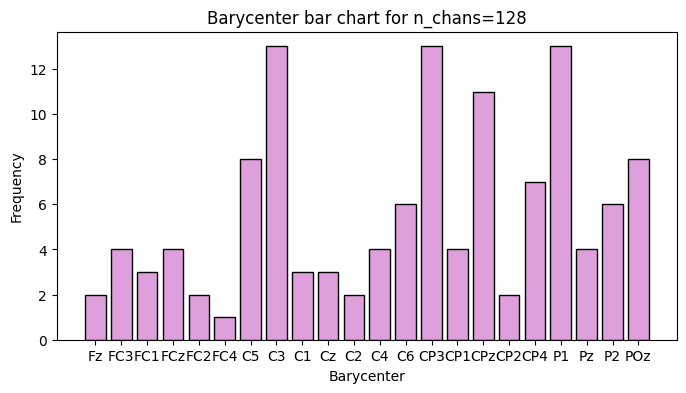

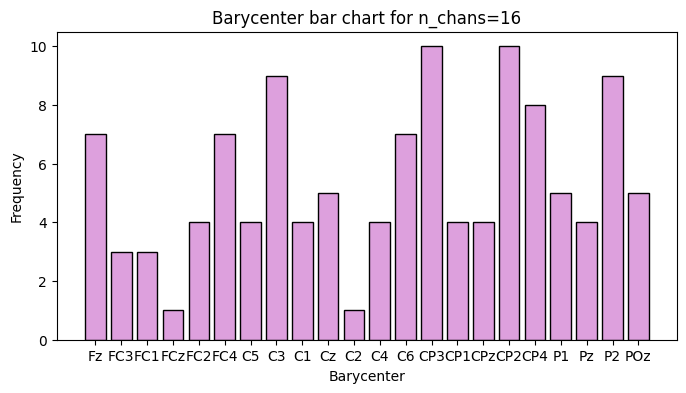

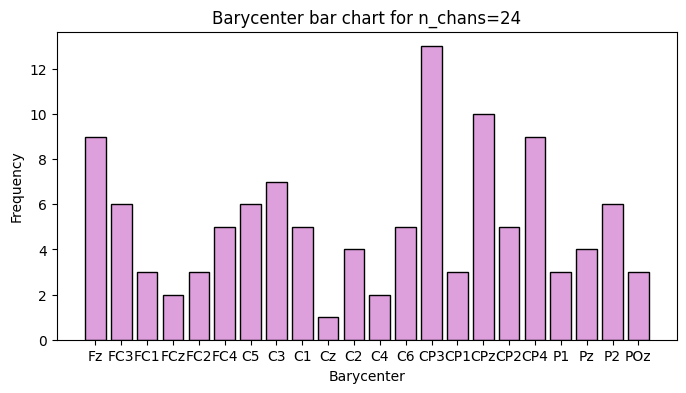

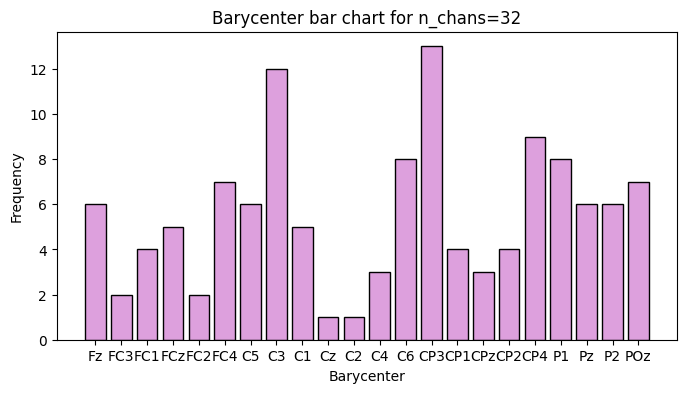

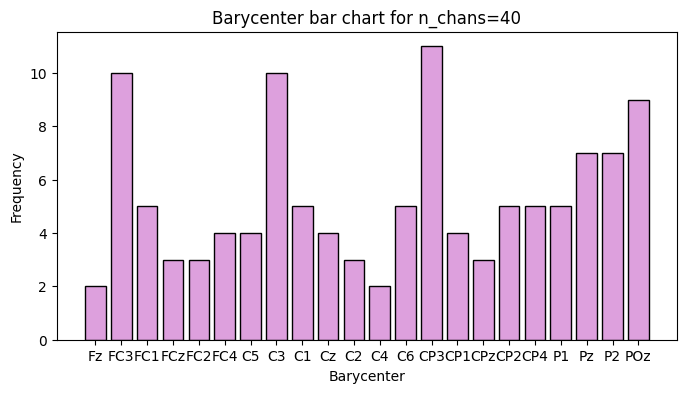

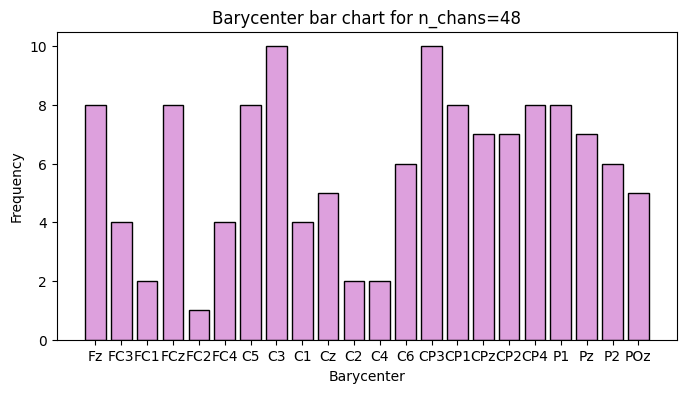

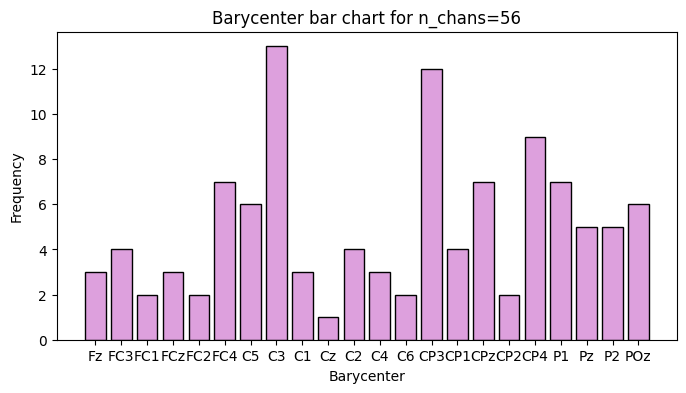

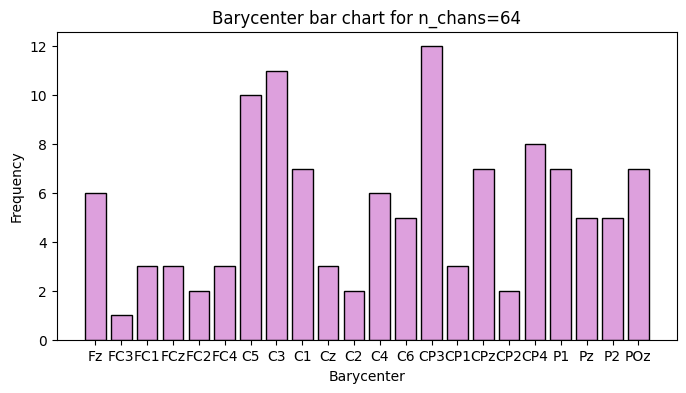

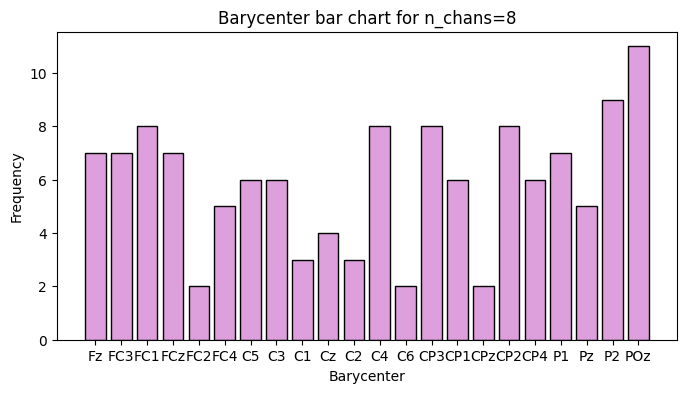

In [83]:
bary_histogram(bary_chans)

### Print model metrics

Model 1 test
Acc train: 0.486375693272245
Acc test: 0.4956605593056895
F1 train: 0.48301411022313756
F1 test: 0.49088216510232785


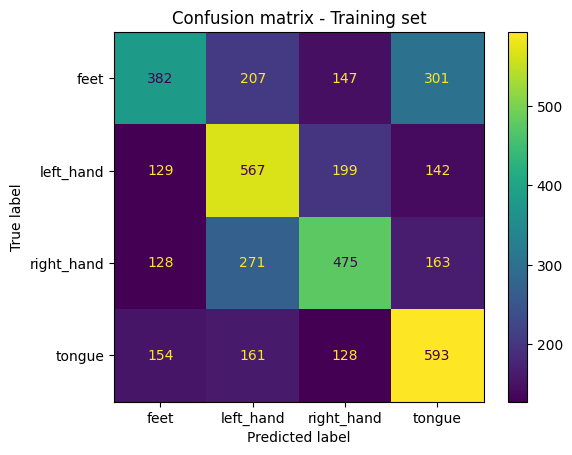

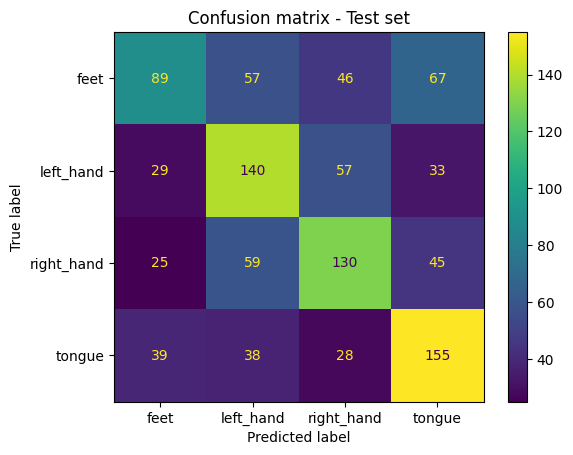

Model 2 test
Acc train: 0.4880636604774536
Acc test: 0.47444551591128253
F1 train: 0.48528121590961126
F1 test: 0.4692090344563111


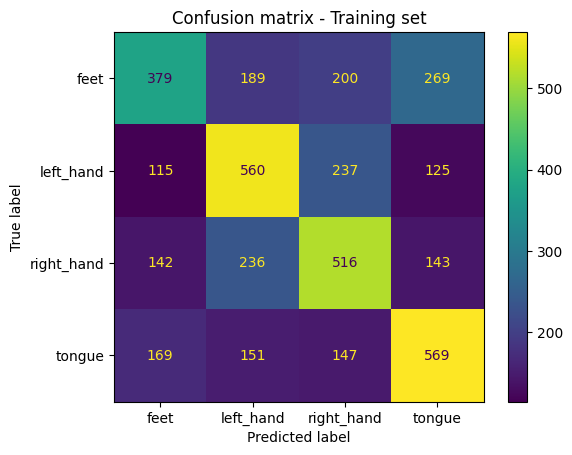

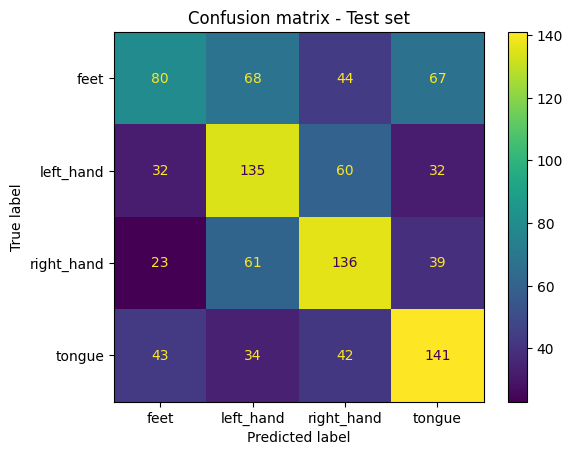

Model 3 test
Acc train: 0.4890282131661442
Acc test: 0.485053037608486
F1 train: 0.486602144015047
F1 test: 0.48046554702295474


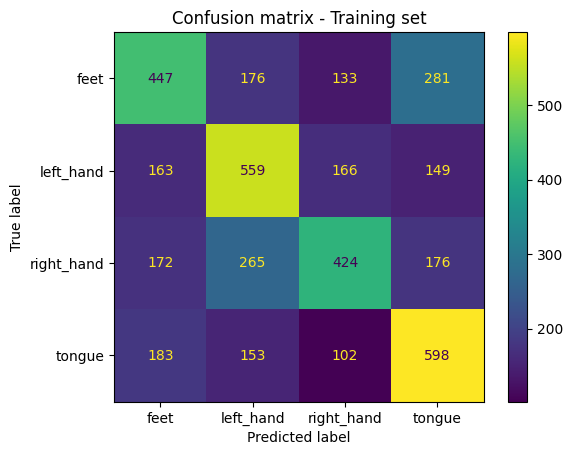

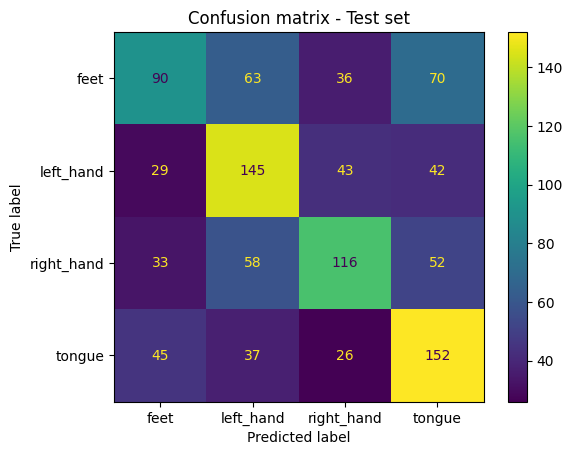

Model 4 test
Acc train: 0.4948155292982879
Acc test: 0.4927675988428158
F1 train: 0.4929487743731311
F1 test: 0.49133406761269793


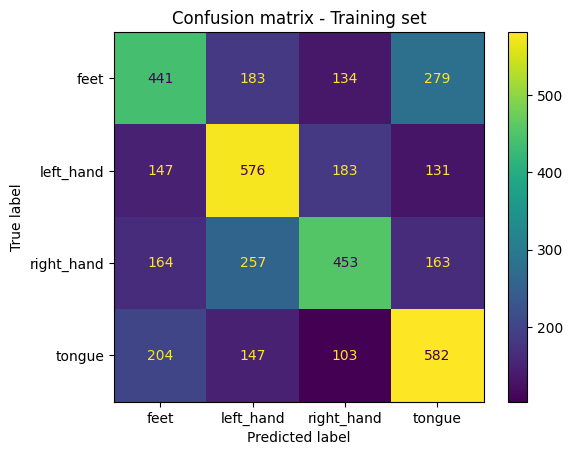

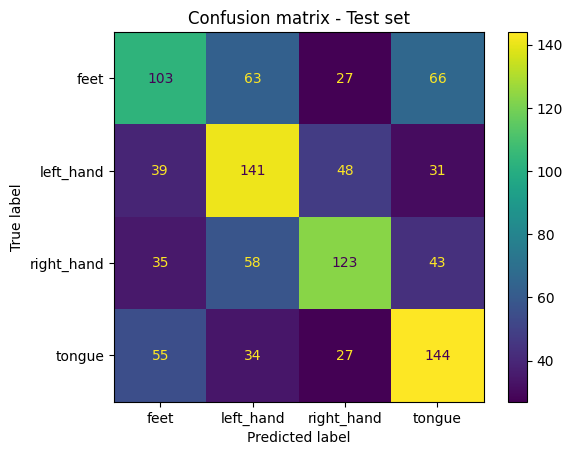

In [222]:
for i in range(mod_runs):
    print(f"Model {i+1} test")
    test_model = mods[i][0].to("cpu").eval()
    mu.model_metrics(test_model, X_train, y_train, X_test, y_test, None, None,plots=plot)

### Print adjacency matrices & graphs

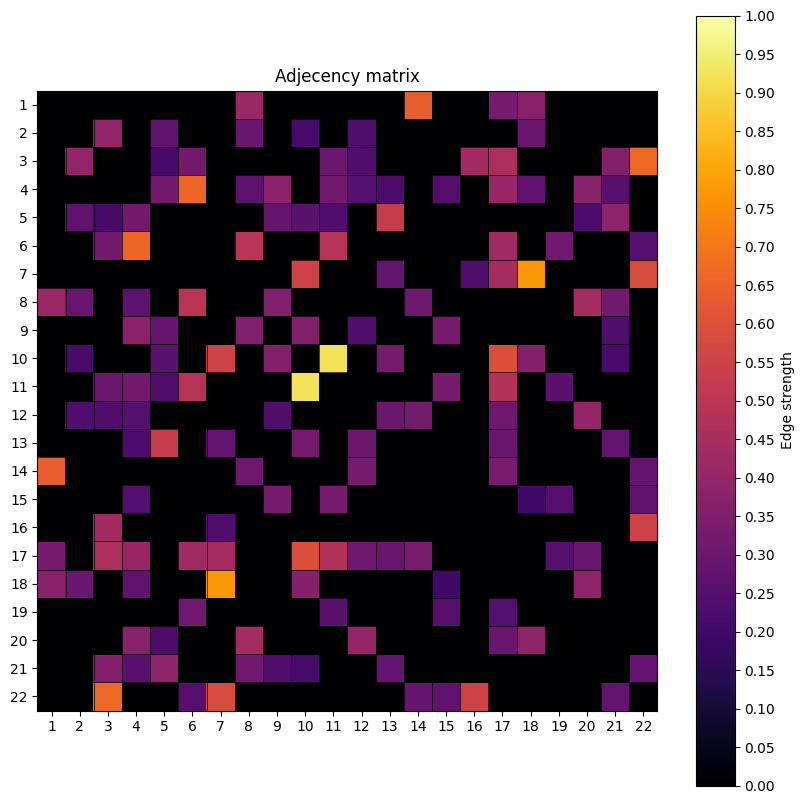

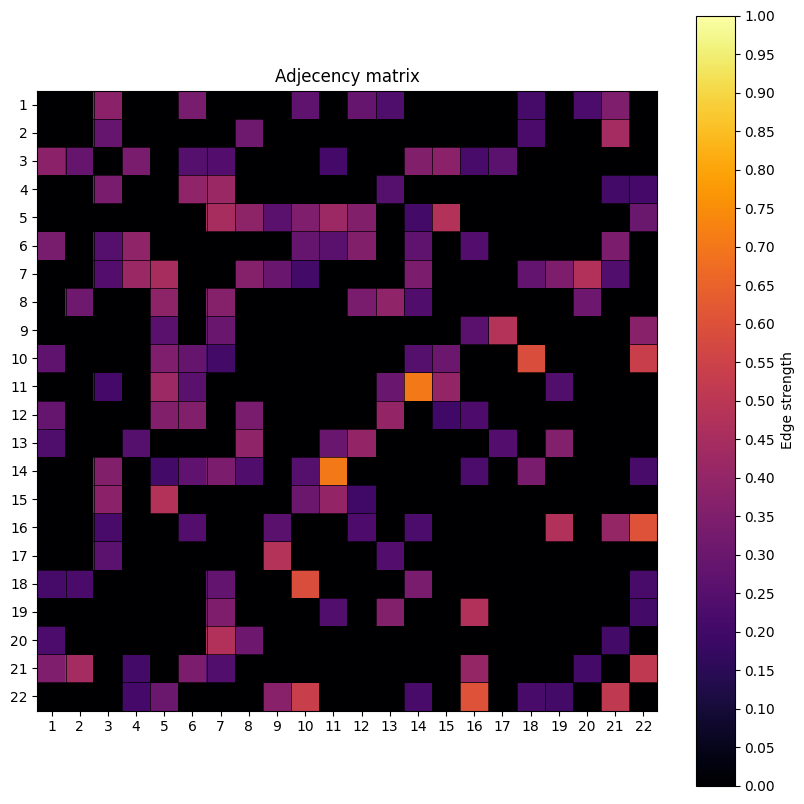

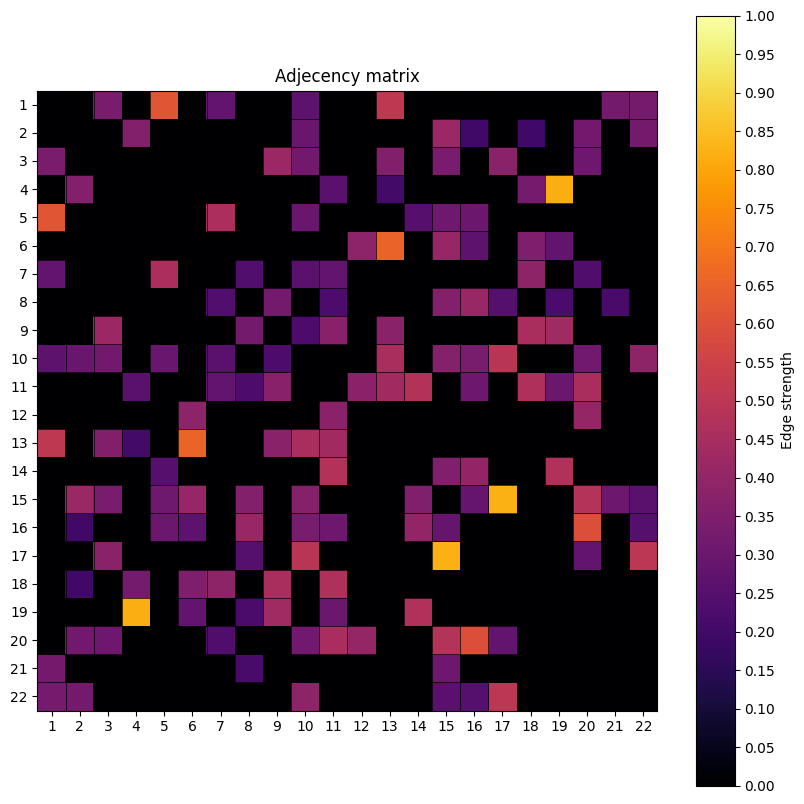

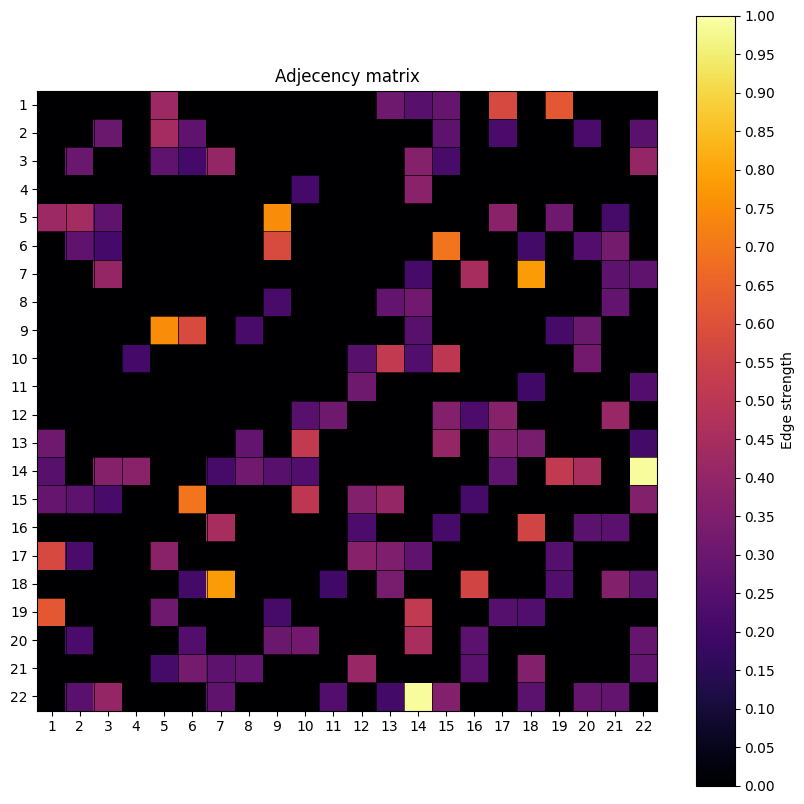

In [224]:
graphs=[]
adj_mats=[]
for i in range(mod_runs):
    adj_mats.append(mu.get_adj_mat(mods[i][0]))
    graphs.append(gu.make_graph(adj_mats[i]))
if plot:
    for adj in adj_mats:
        vu.visualize_adj_mat(adj)
#throw error if isomophic
for G1 in range(len(mods)):
    for G2 in range(G1+1,len(mods)):
        assert gu.check_not_isomorphism(graphs[G1],graphs[G2]), f"Graph G{G1} and G{G2} are isomophic"

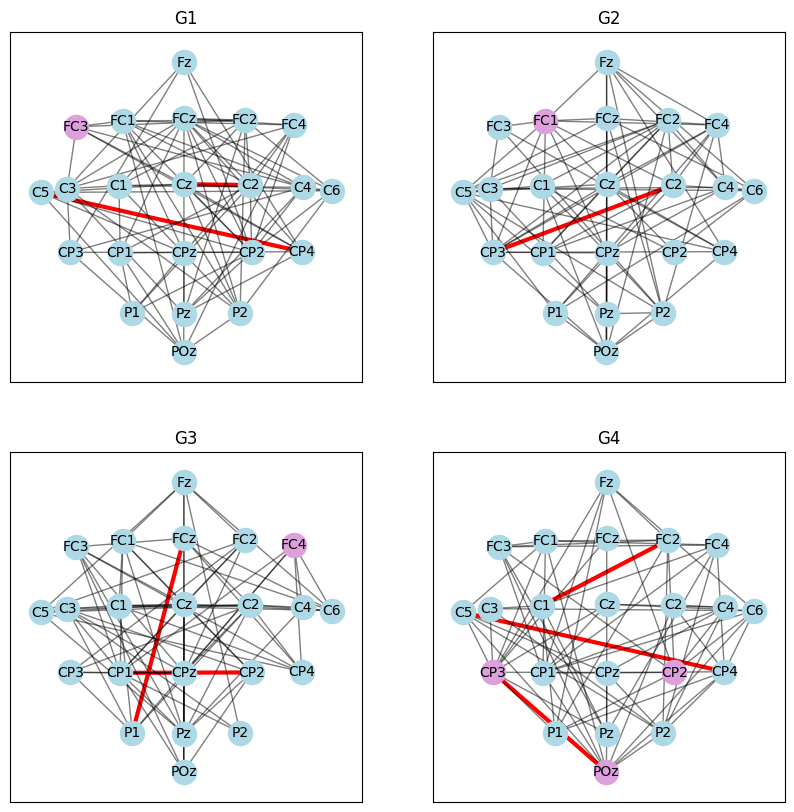

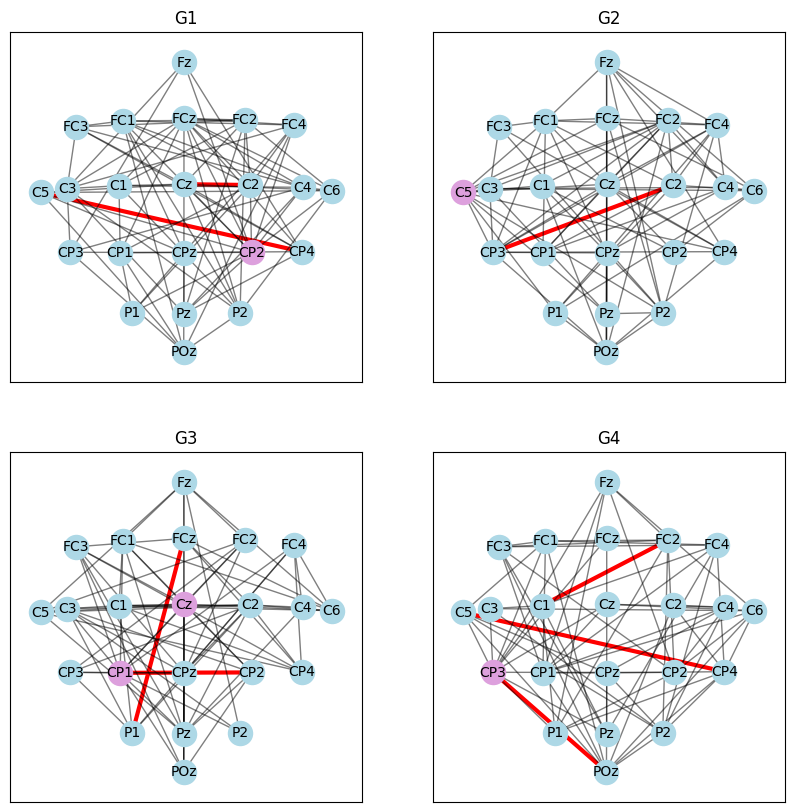

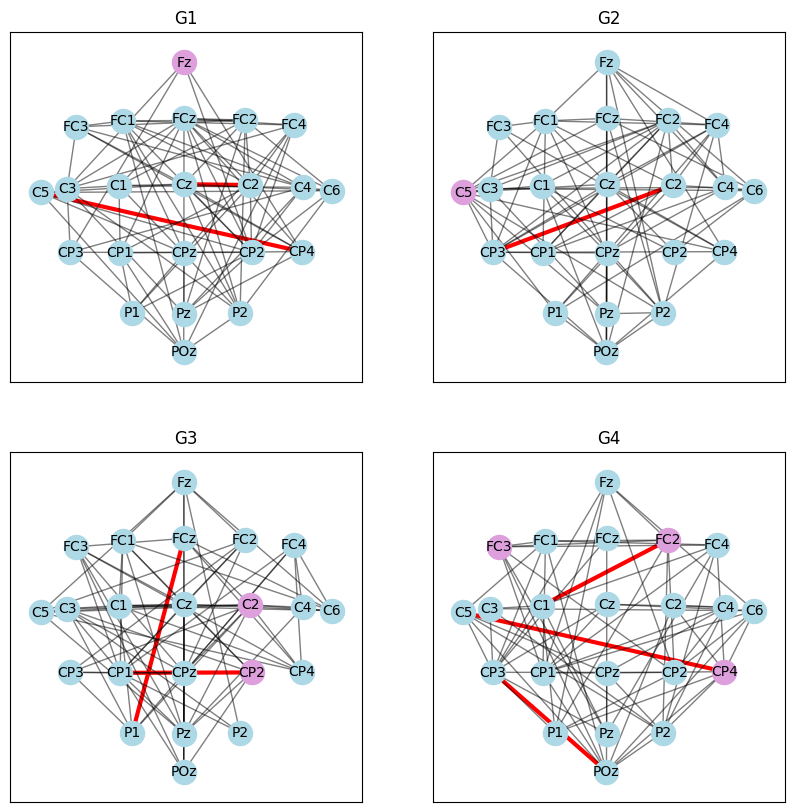

In [225]:
if plot:
    for i in param_list:
        bary_list = barycenters[i]
        vu.graph_plot(adj_mats,vu.graph_visual,2,2,bary_list)

### Plot CKA matrices

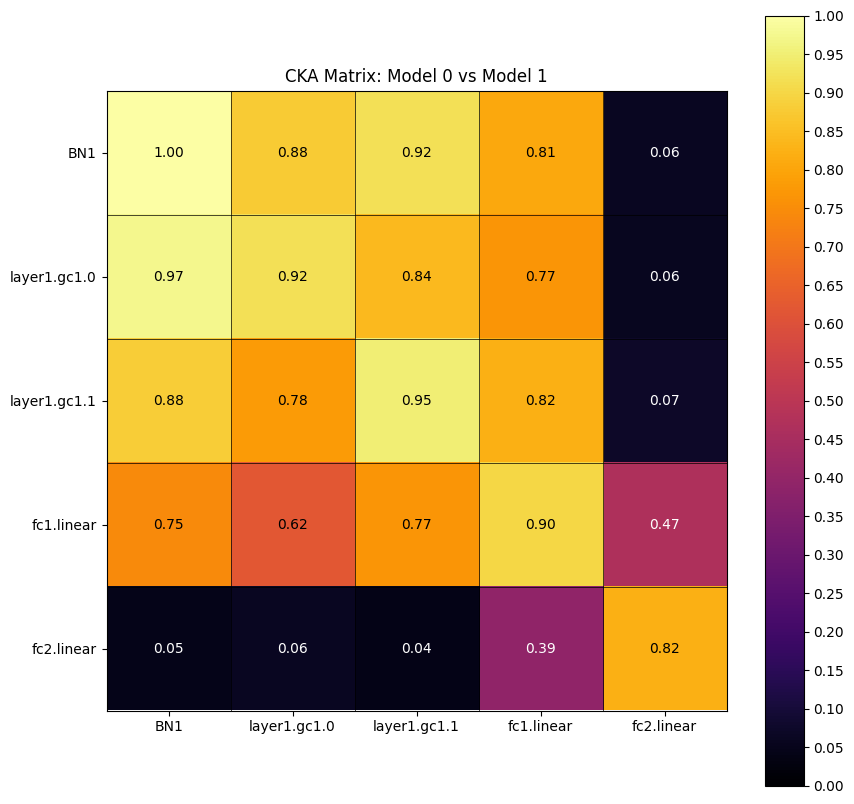

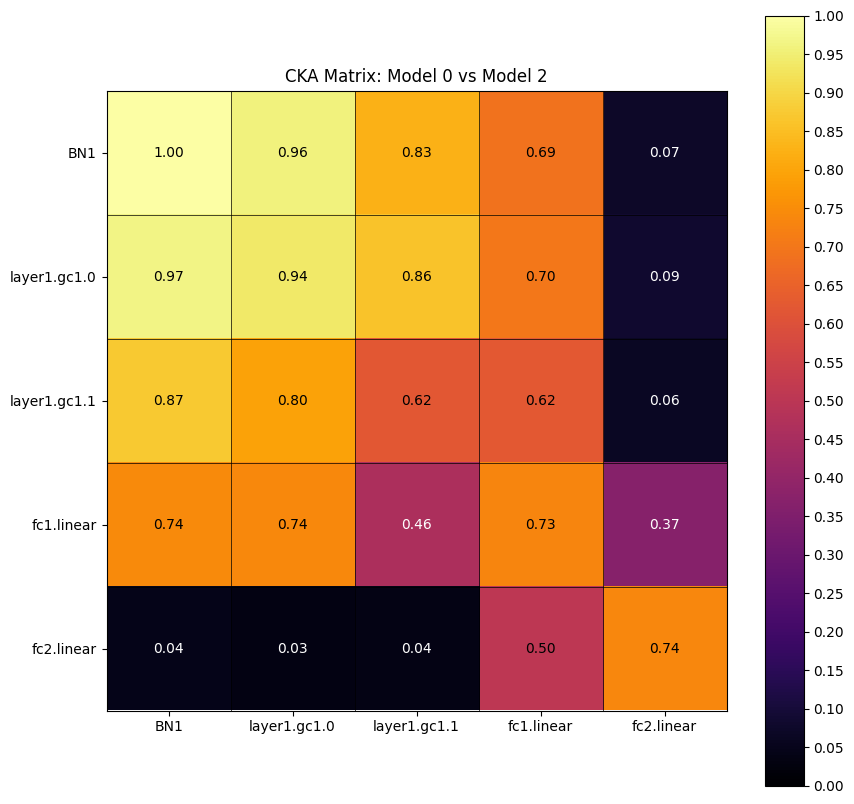

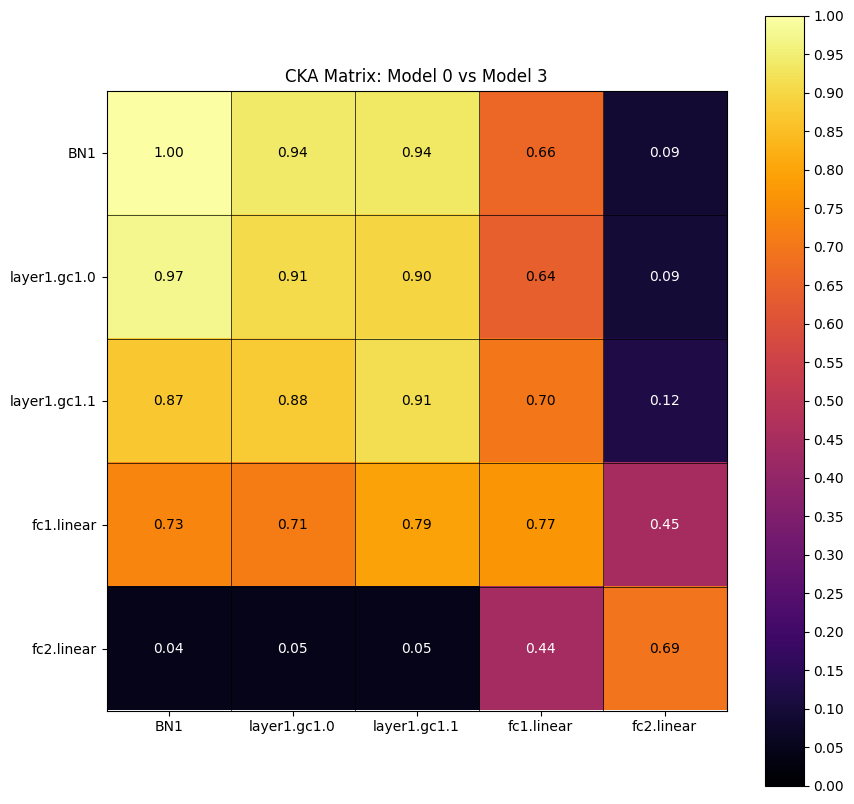

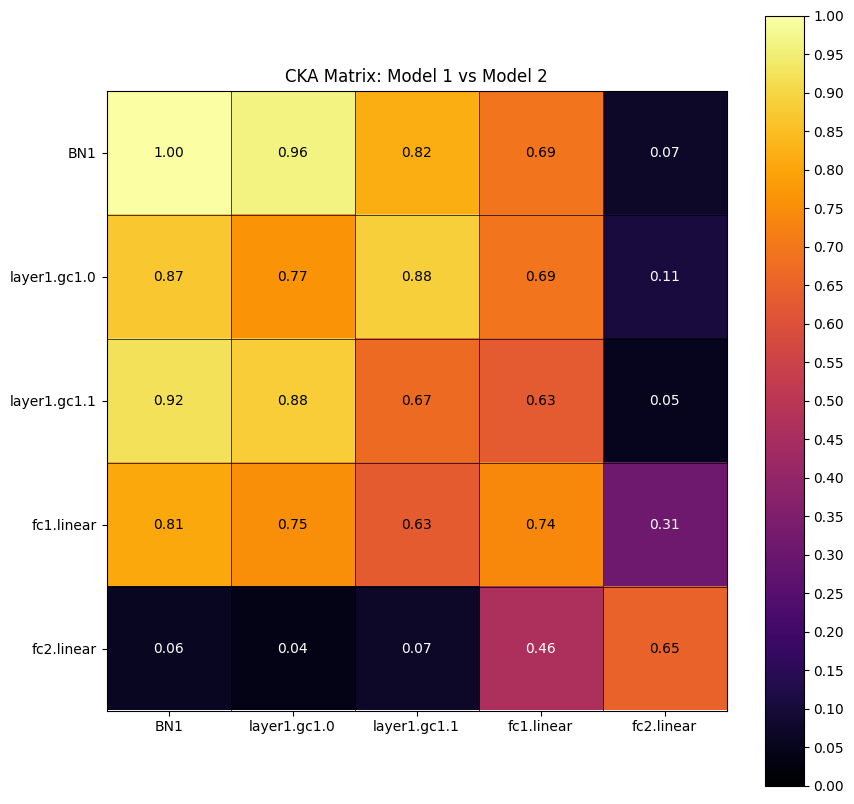

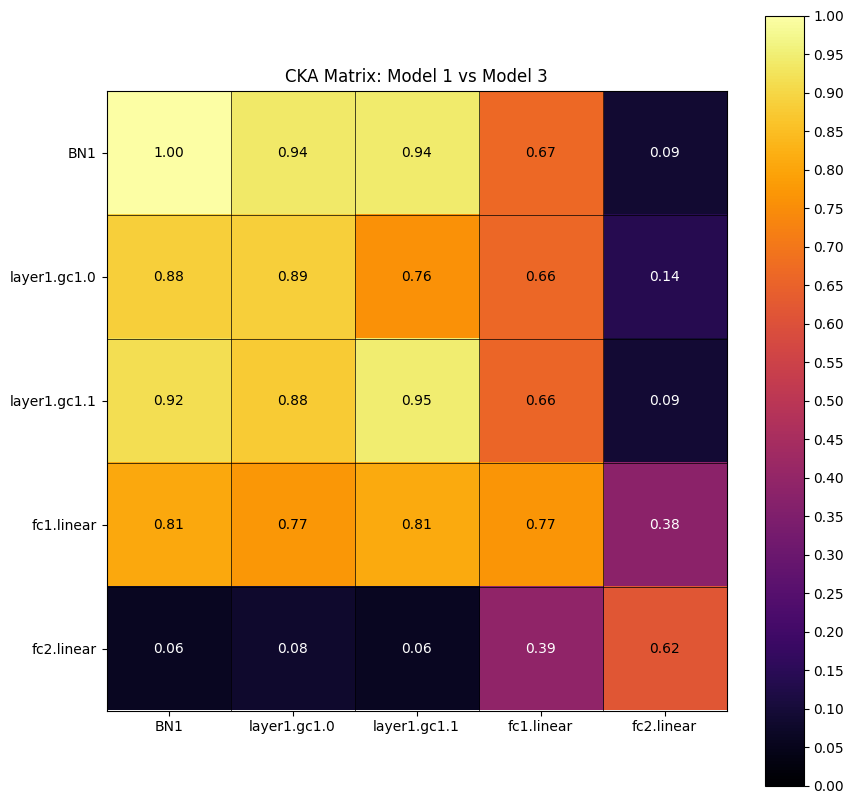

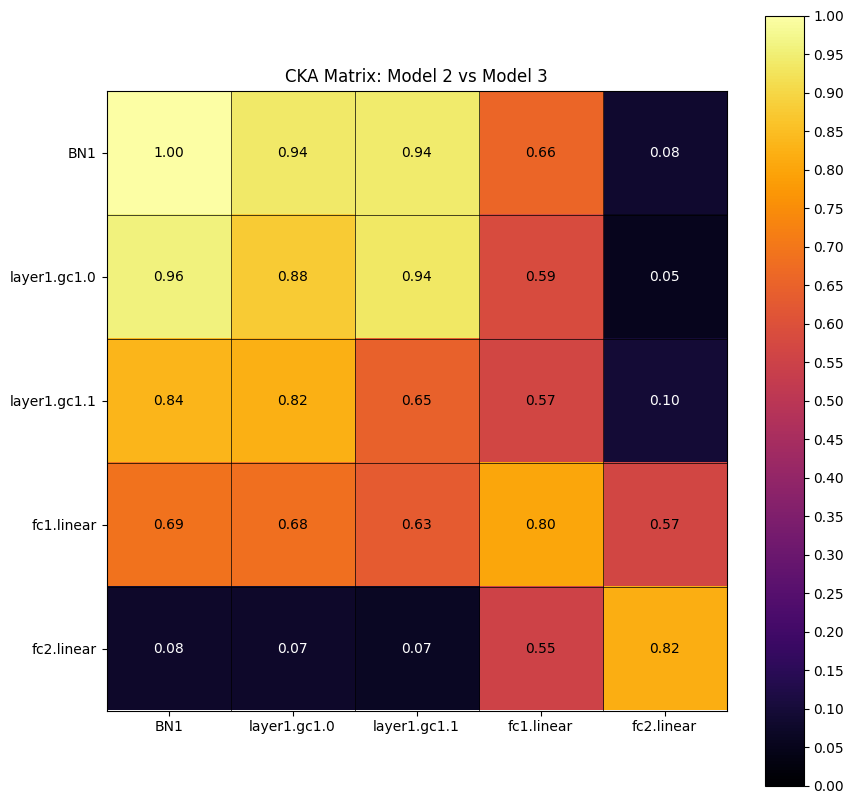

In [228]:
cka_all = []
for i in range(mod_runs-1):
    for j in range(i+1,mod_runs):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                     nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix(train_dataset)
        #calculator.test_cka(10,train_dataset)
        cka_all.append(cka_output)
        if plot:
            vu.plot_matrix(f'CKA Matrix: Model {i} vs Model {j}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

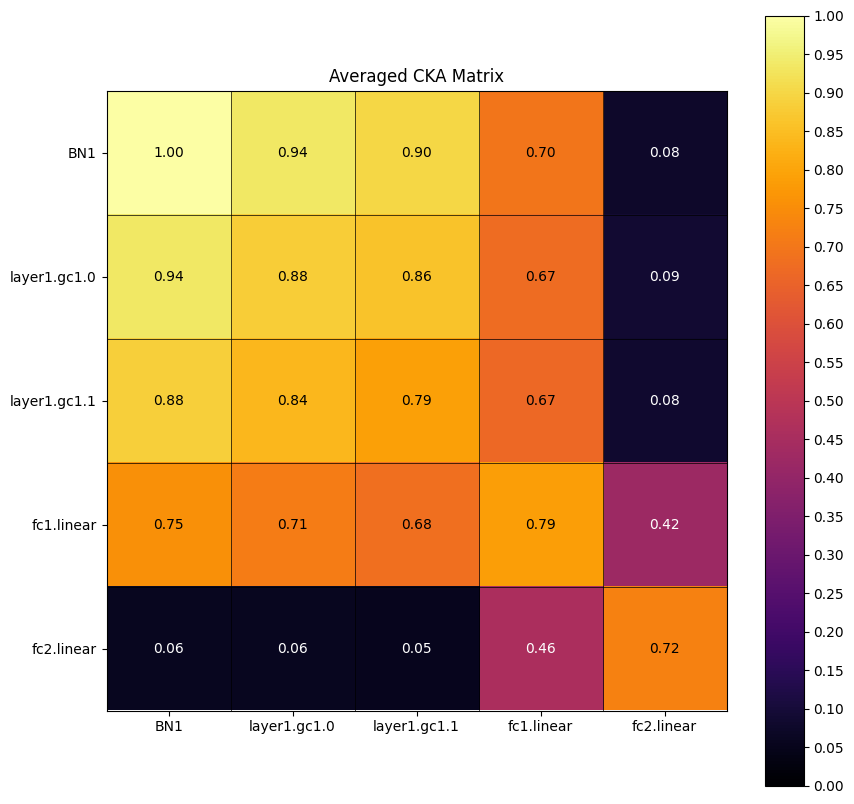

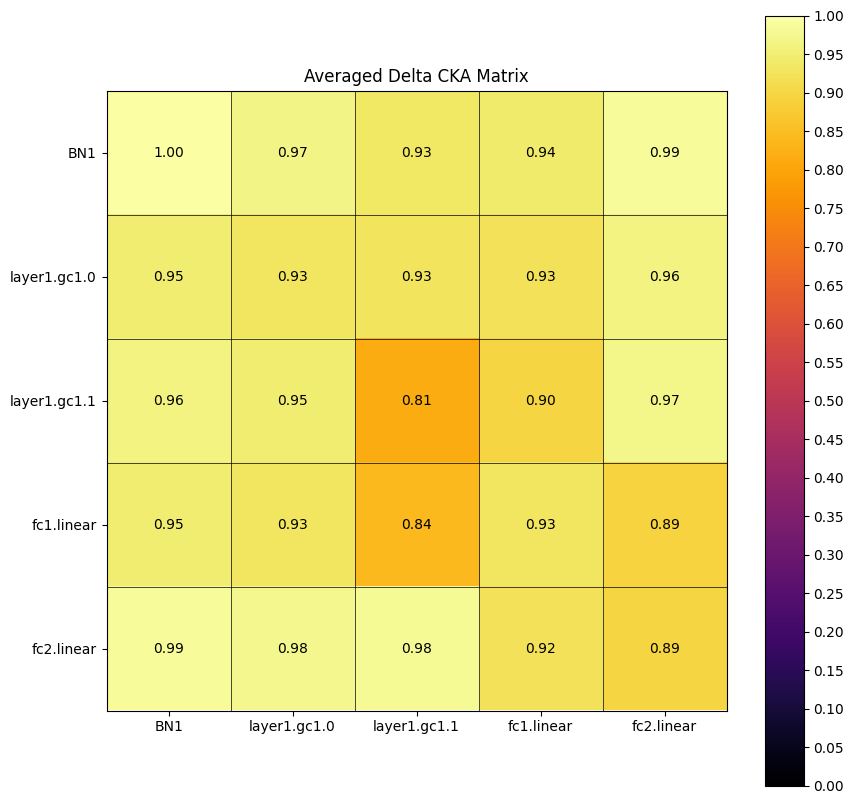

In [229]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  
if plot:
    vu.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)
    vu.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)